# Model training and evaluation

***This notebook contains the main code for the project. It includes the model training and evaluation for DeepLabv3 with ResNet101 and MobileNetV3 backbone layers, and the functions related to the project along with output to help with our analysis.***

In [1]:
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import models

from utils import (
    get_device, train_test_split, batch_data, files_to_tensors,
    pixel_accuracy, iou_score, dice_score, f1_score
)

## Data loading

### Importing dataset

Data we use consist of POEM images and a corresponding 2D tensor comprising of the each pixel's label. The images are imported from a local directory and the tensors are store in a pickled dictionary containing the image file name as keys and tensors as values.

In [2]:
im_dir = "/Users/naman/Workspace/Data/BM5020-POEM/Snapshots"
pkl_path = f"{im_dir}/annotations.pkl"
# pkl_path = "segmented_images.pkl"

classes = ["Background", "Muscle layer", "Mucosal layer", "Electrode"]

with open(pkl_path, "rb") as file:
    data_dict = pickle.load(file)

print(
    f"Size of data: {len(data_dict)}\n"
    f"Classes in data: {classes}"
)

Size of data: 70
Classes in data: ['Background', 'Muscle layer', 'Mucosal layer', 'Electrode']


### Data preprocessing

Here we split the data into train and test sets and bacth the train set.

In [3]:
all_files = list(data_dict.keys())

train_ratio = 0.8
shuffle = True
train_files, test_files = train_test_split(all_files, train_ratio, shuffle)

print(
    f"Train size: {len(train_files)}\n"
    f"Test size: {len(test_files)}"
)

Train size: 56
Test size: 14


In [4]:
batch_size = 8
batched_train = batch_data(train_files, batch_size)

print(f"Number of batches: {len(batched_train)}")

Number of batches: 7


## Loading the models

We load the models with classifier head as DeepLabv3 with 2 different backbones: Resnet101 and MobileNetV3. The classifier head in our model is used to classify each pixel and the backbone layer is used for feature extraction. Backbone layers are initialised with pretrained weights whereas the classifier head is initialised with random weights and 4 number of classes.

In [5]:
device = get_device()

In [6]:
num_classes = len(classes)

deeplabv3_weights = models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
resnet101_weights = models.ResNet101_Weights.IMAGENET1K_V2
mobilenetv3_weights = models.mobilenet.MobileNet_V3_Large_Weights.IMAGENET1K_V2

deeplabv3_resnet101 = models.segmentation.deeplabv3.deeplabv3_resnet101(
    num_classes=num_classes, weights_backbone=resnet101_weights
)
deeplabv3_mobilenetv3 = models.segmentation.deeplabv3.deeplabv3_mobilenet_v3_large(
    num_classes=num_classes, weights_backbone=mobilenetv3_weights
)

In [7]:
# Choose the model to train
model = deeplabv3_mobilenetv3

model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

## Model training and analysis

### Loading the optimizer and scheduler

We use the Adam optimizer with exponential scheduling. $\gamma$ in our scheduler is the factor multiplied after each step of the scheduler (which is taken after every epoch). Hence, the learning rate at $i\text{th}$ epoch will be $\text{initial\_lr} * \gamma^i$.

In [10]:
initial_lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

gamma = 0.8
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

### Training loop

In [11]:
epochs = 40
batches = len(batched_train)

loss_list = []
accuracy_list = []
iou_list = [[] for _ in range(classes)]
dice_list = [[] for _ in range(classes)]
f1_list = [[] for _ in range(classes)]
lr_vals = []

for epoch in range(epochs):

    epoch_loss = 0
    epoch_accuracy = 0
    epoch_iou_list = [0] * num_classes
    epoch_dice_list = [0] * num_classes
    epoch_f1_list = [0] * num_classes

    for batch in batched_train:

        inputs, labels = files_to_tensors(batch, im_dir, data_dict)
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs)["out"]

        loss = F.cross_entropy(logits, labels)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

        predictions = logits.argmax(dim=1).cpu()
        labels = labels.cpu()
        epoch_accuracy += pixel_accuracy(predictions, labels)

        for i in range(num_classes):
            epoch_iou_list[i] += iou_score(predictions == i, labels == i)
            epoch_dice_list[i] += dice_score(predictions == i, labels == i)
            epoch_f1_list[i] += f1_score(predictions == i, labels == i)

    lr_val = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_vals.append(lr_val)
    scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs} average loss: {epoch_loss / batches}")

    loss_list.append(epoch_loss / batches)
    accuracy_list.append(epoch_accuracy / batches)
    for i in range(num_classes):
        iou_list[i].append(epoch_iou_list[i] / batches)
        dice_list[i].append(epoch_dice_list[i] / batches)
        f1_list[i].append(epoch_f1_list[i] / batches)

/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:125: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * precisions * recalls / (precisions + recalls)
/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:124: RuntimeWarning: invalid value encountered in divide
  recalls = intersections / true_labels.sum(axis=(1, 2))
/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:123: RuntimeWarning: invalid value encountered in divide
  precisions = intersections / predicted_labels.sum(axis=(1, 2))
/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:106: RuntimeWarning: invalid value encountered in divide
  iou_scores = intersections / unions
/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:115: RuntimeWarning: invalid value encountered in divide
  dice_scores = intersections / denominator


Epoch 1/40 average loss: 1.0446375438145228
Epoch 2/40 average loss: 0.7564975363867623
Epoch 3/40 average loss: 0.6467711159161159
Epoch 4/40 average loss: 0.5927108866827828
Epoch 5/40 average loss: 0.5519525749342782
Epoch 6/40 average loss: 0.5794266206877572
Epoch 7/40 average loss: 0.5561933900628772
Epoch 8/40 average loss: 0.4936207447733198
Epoch 9/40 average loss: 0.46313109142439707
Epoch 10/40 average loss: 0.4618192953722818
Epoch 11/40 average loss: 0.457525406564985
Epoch 12/40 average loss: 0.42337434206690105
Epoch 13/40 average loss: 0.3878916416849409
Epoch 14/40 average loss: 0.37666615418025423
Epoch 15/40 average loss: 0.37746612089020865
Epoch 16/40 average loss: 0.37253311702183317
Epoch 17/40 average loss: 0.3610386209828513
Epoch 18/40 average loss: 0.3540887066296169
Epoch 19/40 average loss: 0.3502408138343266
Epoch 20/40 average loss: 0.34776785543986727
Epoch 21/40 average loss: 0.3437076381274632
Epoch 22/40 average loss: 0.33900335856846403
Epoch 23/40 a

### Plots and analysis

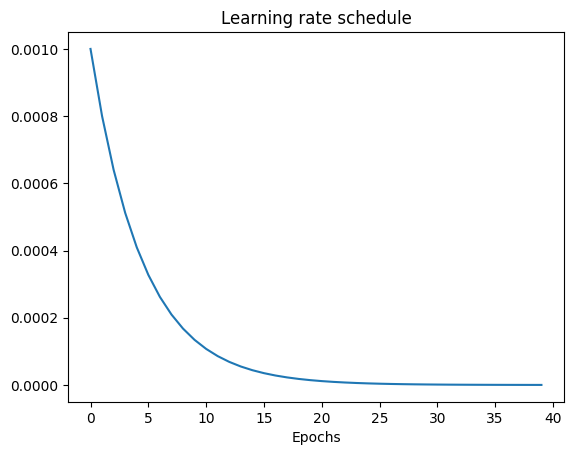

In [13]:
# Plot learning rate schedule
plt.plot(lr_vals)
plt.xlabel("Epochs")
plt.title("Learning rate schedule")
plt.show()

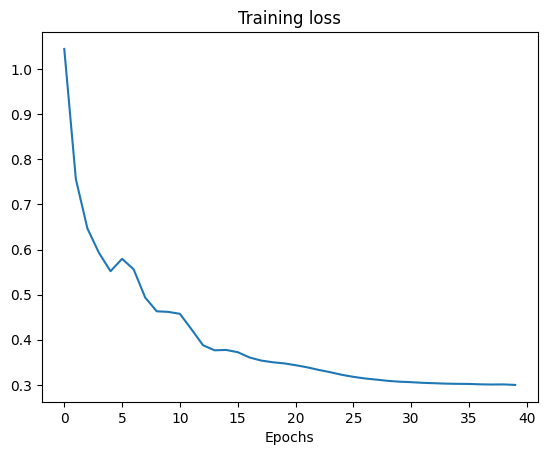

In [12]:
# Plot loss
plt.plot(loss_list)
plt.xlabel("Epochs")
plt.title("Training loss")
plt.show()

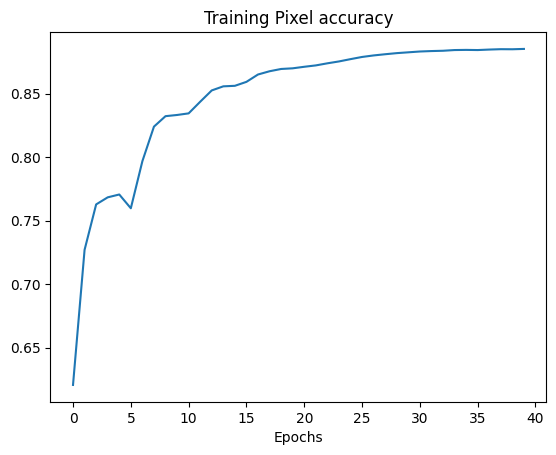

In [14]:
# Plot pixel accuracy
plt.plot(accuracy_list)
plt.xlabel("Epochs")
plt.title("Training Pixel accuracy")
plt.show()

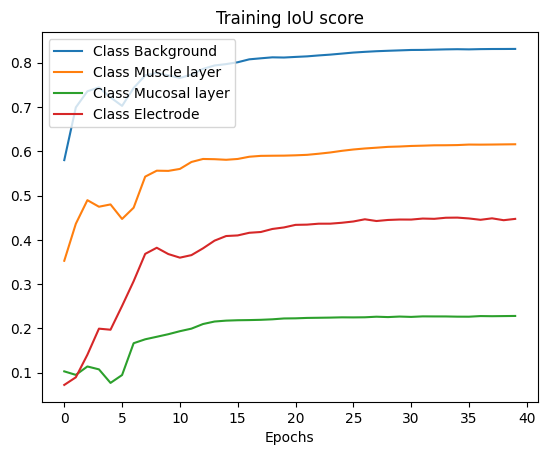

In [31]:
# Plot IoU scores
for i, class_ in enumerate(classes):
    plt.plot(iou_list[i], label=f"Class {class_}")
plt.xlabel("Epochs")
plt.title(f"Training IoU score")
plt.legend()
plt.show()

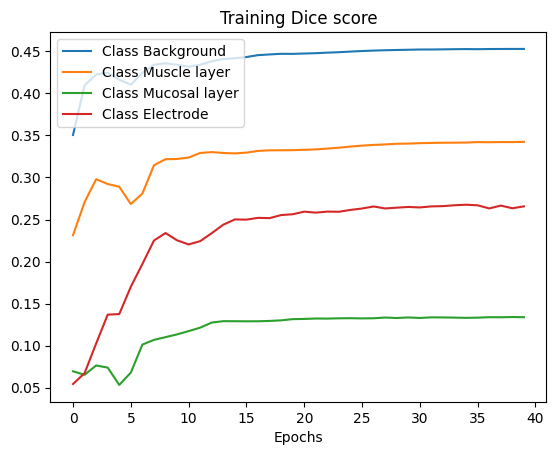

In [32]:
# Plot Dice scores
for i, class_ in enumerate(classes):
    plt.plot(dice_list[i], label=f"Class {class_}")
plt.xlabel("Epochs")
plt.title(f"Training Dice score")
plt.legend()
plt.show()

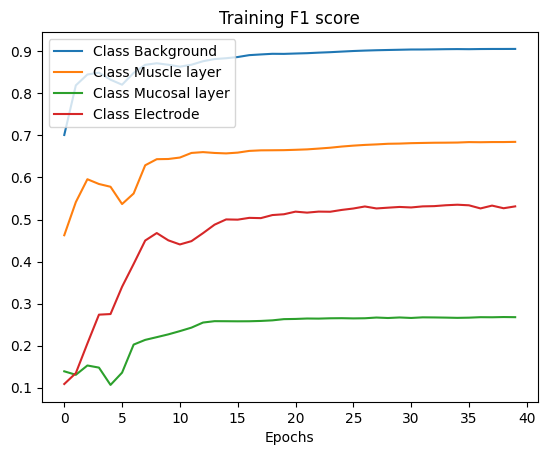

In [33]:
# Plot F1 scores
for i, class_ in enumerate(classes):
    plt.plot(f1_list[i], label=f"Class {class_}")
plt.xlabel("Epochs")
plt.title(f"Training F1 score")
plt.legend()
plt.show()

## Model evaluation

In [20]:
test_inputs, test_labels = files_to_tensors(test_files, im_dir, data_dict)
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

with torch.no_grad():
    logits = model(test_inputs)["out"]

test_labels = test_labels.cpu()
predictions = logits.argmax(dim=1).cpu()

In [34]:
print(
    f"Test loss: {F.cross_entropy(logits, test_labels.to(device))}\n"
    f"Pixel accuracy on test set: {pixel_accuracy(predictions, test_labels)}\n"
)
for i, class_ in enumerate(classes):
    print(
        f"Class {class_} IoU score: {iou_score(predictions == i, test_labels == i)}\n"
        f"Class {class_} Dice score: {dice_score(predictions == i, test_labels == i)}\n"
        f"Class {class_} F1 score: {f1_score(predictions == i, test_labels == i)}\n"
    )

Test loss: 0.8640486598014832
Pixel accuracy on test set: 0.7213297917733401

Class Background IoU score: 0.7765148710055038
Class Background Dice score: 0.4357951954857305
Class Background F1 score: 0.871590390971461

Class Muscle layer IoU score: 0.3255124289818077
Class Muscle layer Dice score: 0.20264831679731657
Class Muscle layer F1 score: 0.4052966335946331

Class Mucosal layer IoU score: 0.23377037087277922
Class Mucosal layer Dice score: 0.14675010340421224
Class Mucosal layer F1 score: 0.2935002068084245

Class Electrode IoU score: 0.2717397708756395
Class Electrode Dice score: 0.18356278047955302
Class Electrode F1 score: 0.36712556095910603



/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:123: RuntimeWarning: invalid value encountered in divide
  precisions = intersections / predicted_labels.sum(axis=(1, 2))
/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:124: RuntimeWarning: invalid value encountered in divide
  recalls = intersections / true_labels.sum(axis=(1, 2))
/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:125: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * precisions * recalls / (precisions + recalls)


## Saving the model

Save the pretrained model's state dictionary in a `.pth` file.

In [23]:
out_file = "model-state-dict.pth"

torch.save(model.to("cpu").state_dict(), out_file)